In [1]:
# Image Classification with Convolutional Neural Networks
# Instructions
# Assignment 1: Image Classification with Convolutional Neural Networks

# Objective: The goal of this assignment is to deepen your understanding of Convolutional Neural Networks (CNNs) by implementing a robust, advanced architecture for image classification.
# You will explore advanced CNN concepts such as dropout, batch normalization, data augmentation, and residual connections while benchmarking your model's performance against existing methods.

In [2]:
# Dataset: CIFAR-10 or CIFAR-100. These datasets are widely used in the machine learning community and will allow you to compare your model's performance with reported benchmarks

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

# Data Pre-processing

a. Load and preprocess the dataset, including normalization and data augmentation techniques such as random cropping, horizontal flipping, and color jittering to improve generalization.

### Evaluating the mean and standard deviation of the training dataset to normalize the training and test datasets

In [ ]:
# Load the CIFAR-100 dataset without any transformations
dataset = datasets.CIFAR100(
    root='./data',  # Path to store the dataset
    train=True,  # Use the training set
    download=True,  # Download the dataset if it doesn't exist
    transform=transforms.ToTensor(),  # Convert images to tensors
)

# Create a DataLoader to iterate through the dataset
data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

# Initialize variables to accumulate pixel values
mean = torch.zeros(3)  # Mean for 3 channels (R, G, B)
std = torch.zeros(3)   # Standard deviation for 3 channels (R, G, B)

# Iterate through the dataset to compute mean and std
for images, _ in data_loader:
    # Compute mean and std for each channel
    for i in range(3):  # Loop over the 3 channels (R, G, B)
        mean[i] = images[:, i, :, :].mean()
        std[i] = images[:, i, :, :].std()

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

### Loading the train and test dataset with following transformations:

#### Train dataset:
1.   Horizontal Flip
2.   Random Cropping
3.   Color Jittering
4.   Converting to tensor
5.   Normalizing using the mean and standard deviation obtained above

#### Test dataset:
1.   Converting to tensor
2.   Normalizing using the mean and standard deviation obtained above

In [4]:
# Define transformations for the training dataset
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color Jittering
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean, std),  # Normalize with CIFAR-100 mean and std
])

# Define transformations for the testing dataset
transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean, std),  # Normalize with CIFAR-100 mean and std
])

# Load the CIFAR-100 training dataset
train_dataset = datasets.CIFAR100(
    root='./data',  # Path to store the dataset
    train=True,  # Load the training set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform_train,  # Apply the training transformations
)

# Load the CIFAR-100 testing dataset
test_dataset = datasets.CIFAR100(
    root='./data',  # Path to store the dataset
    train=False,  # Load the testing set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform_test,  # Apply the testing transformations
)

# Create data loaders for training and testing
batch_size = 64  # Number of samples per batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle the training data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Do not shuffle the testing data

# Print dataset details
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")

Training dataset size: 50000
Testing dataset size: 10000
Number of classes: 100


b. Convert labels into one-hot encoded vectors and split the data into training, validation, and testing subsets.

In [6]:
# Convert labels to one-hot encoded vectors
def one_hot_encode(labels, num_classes=100):
    return F.one_hot(torch.tensor(labels), num_classes=num_classes)

# Apply one-hot encoding to the training and testing labels
train_dataset.targets = one_hot_encode(train_dataset.targets)
test_dataset.targets = one_hot_encode(test_dataset.targets)

# Split the training dataset into training and validation subsets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for training, validation, and testing
batch_size = 64  # Number of samples per batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle the training data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Do not shuffle the validation data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Do not shuffle the testing data

# Print dataset details
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.dataset.targets[0])}")  # Number of classes (100 for CIFAR-100)

Training dataset size: 40000
Validation dataset size: 10000
Testing dataset size: 10000
Number of classes: 100


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, activation='relu'):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection if input and output dimensions don't match
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        # Activation function
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)  # Residual connection
        out = self.activation(out)
        return out

class CNN(nn.Module):
    def __init__(self, num_classes=100):
        super(CNN, self).__init__()
        self.in_channels = 64

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer1 = self._make_layer(64, 2, stride=1, activation='relu')
        self.layer2 = self._make_layer(128, 2, stride=2, activation='leaky_relu')
        self.layer3 = self._make_layer(256, 2, stride=2, activation='relu')
        self.layer4 = self._make_layer(512, 2, stride=2, activation='leaky_relu')

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride, activation):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride, activation))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))  # Global average pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Create the model
model = CNN(num_classes=100)
print(model)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (activation): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [9]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Convert one-hot encoded labels to class indices
        labels = torch.argmax(labels, dim=1)  # Shape: (batch_size,)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Use class indices for loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

Epoch [1/10], Loss: 4.180600309753418
Epoch [2/10], Loss: 3.7010858730316163
Epoch [3/10], Loss: 3.4149109748840334
Epoch [4/10], Loss: 3.206293747329712
Epoch [5/10], Loss: 3.031036769104004
Epoch [6/10], Loss: 2.8902068378448487
Epoch [7/10], Loss: 2.781661339187622
Epoch [8/10], Loss: 2.6750270671844483
Epoch [9/10], Loss: 2.5879315204620363
Epoch [10/10], Loss: 2.515890392112732


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Training Loss: 4.1893, Validation Loss: 3.8777, Validation Accuracy: 9.85%
Epoch [2/20], Training Loss: 3.6933, Validation Loss: 3.4039, Validation Accuracy: 17.58%
Epoch [3/20], Training Loss: 3.3985, Validation Loss: 3.2181, Validation Accuracy: 20.50%
Epoch [4/20], Training Loss: 3.1708, Validation Loss: 3.0526, Validation Accuracy: 24.26%
Epoch [5/20], Training Loss: 3.0010, Validation Loss: 2.8374, Validation Accuracy: 28.10%
Epoch [6/20], Training Loss: 2.8649, Validation Loss: 2.6898, Validation Accuracy: 31.17%
Epoch [7/20], Training Loss: 2.7479, Validation Loss: 2.6835, Validation Accuracy: 30.76%
Epoch [8/20], Training Loss: 2.6542, Validation Loss: 2.5723, Validation Accuracy: 33.21%
Epoch [9/20], Training Loss: 2.5648, Validation Loss: 2.4985, Validation Accuracy: 35.59%
Epoch [10/20], Training Loss: 2.4934, Validation Loss: 2.4539, Validation Accuracy: 35.93%
Epoch [11/20], Training Loss: 2.4195, Validation Loss: 2.3593, Validation Accuracy: 37.99%
Epoch [12

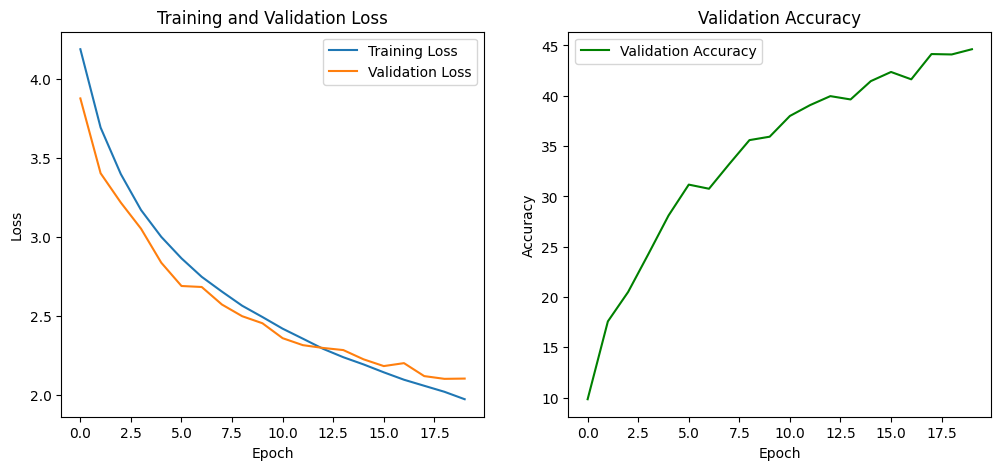

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the model, optimizer, and loss function
model = CNN(num_classes=100).to(device)  # Move model to GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Lists to store training/validation loss and accuracy
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Convert one-hot encoded labels to class indices
        labels = torch.argmax(labels, dim=1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert one-hot encoded labels to class indices
            labels = torch.argmax(labels, dim=1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print training and validation results
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {train_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

    # Step the learning rate scheduler
    scheduler.step(val_loss)

# Plot loss curves
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()

## CIFAR-10 Dataset

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define transformations for the training and testing datasets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),  # Normalize with CIFAR-10 mean and std
])

transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),  # Normalize with CIFAR-10 mean and std
])

# Load the CIFAR-10 training dataset
train_dataset = datasets.CIFAR10(
    root='./data',  # Path to store the dataset
    train=True,  # Load the training set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform_train,  # Apply the training transformations
)

# Load the CIFAR-10 testing dataset
test_dataset = datasets.CIFAR10(
    root='./data',  # Path to store the dataset
    train=False,  # Load the testing set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform_test,  # Apply the testing transformations
)

# Split the training dataset into training and validation subsets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for training, validation, and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, activation='relu', kernel_size=3, num_classes=10):
        super(CNN, self).__init__()
        self.activation = activation
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.apply_activation(self.bn1(self.conv1(x)))
        x = self.pool(self.apply_activation(self.bn2(self.conv2(x))))
        x = self.apply_activation(self.bn3(self.conv3(x)))
        x = self.pool(self.apply_activation(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(self.apply_activation(self.fc1(x)))
        x = self.fc2(x)
        return x

    def apply_activation(self, x):
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'leaky_relu':
            return F.leaky_relu(x, negative_slope=0.1)
        elif self.activation == 'gelu':
            return F.gelu(x)
        else:
            raise ValueError(f"Unsupported activation: {self.activation}")

# Hyperparameters to tune
activations = ['relu', 'leaky_relu', 'gelu']
kernel_sizes = [3, 5]
optimizers_list = ['adam', 'sgd']

# Store results
results = []

# Hyperparameter tuning loop
for activation in activations:
    for kernel_size in kernel_sizes:
        for optimizer_name in optimizers_list:
            print(f"\nTraining with activation={activation}, kernel_size={kernel_size}, optimizer={optimizer_name}")

            # Create the model
            model = CNN(activation=activation, kernel_size=kernel_size, num_classes=10).to(device)

            # Define loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            if optimizer_name == 'adam':
                optimizer = optim.Adam(model.parameters(), lr=0.001)
            elif optimizer_name == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            else:
                raise ValueError(f"Unsupported optimizer: {optimizer_name}")

            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

            # Training loop
            num_epochs = 10  # Train for fewer epochs for tuning
            best_val_accuracy = 0.0

            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                train_loss = running_loss / len(train_loader)
                train_accuracy = 100 * correct / total

                # Validation loop
                model.eval()
                val_loss = 0.0
                correct = 0
                total = 0

                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)

                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()

                        _, predicted = torch.max(outputs, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                val_loss = val_loss / len(val_loader)
                val_accuracy = 100 * correct / total

                # Save the best validation accuracy
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy

                print(f"Epoch [{epoch+1}/{num_epochs}], "
                      f"Training Loss: {train_loss:.4f}, "
                      f"Validation Loss: {val_loss:.4f}, "
                      f"Validation Accuracy: {val_accuracy:.2f}%")

                # Step the learning rate scheduler
                scheduler.step(val_loss)

            # Store the results
            results.append({
                'activation': activation,
                'kernel_size': kernel_size,
                'optimizer': optimizer_name,
                'best_val_accuracy': best_val_accuracy
            })

# Print the results
print("\nHyperparameter Tuning Results:")
for result in results:
    print(result)

# Find the best model
best_result = max(results, key=lambda x: x['best_val_accuracy'])
print(f"\nBest Model: {best_result}")

Using device: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]



Training with activation=relu, kernel_size=3, optimizer=adam
Epoch [1/10], Training Loss: 2.3096, Validation Loss: 1.7219, Validation Accuracy: 36.41%
Epoch [2/10], Training Loss: 1.6126, Validation Loss: 1.9599, Validation Accuracy: 32.98%
Epoch [3/10], Training Loss: 1.4488, Validation Loss: 1.3738, Validation Accuracy: 51.89%
Epoch [4/10], Training Loss: 1.3193, Validation Loss: 1.2397, Validation Accuracy: 53.84%
Epoch [5/10], Training Loss: 1.2183, Validation Loss: 1.0688, Validation Accuracy: 61.81%
Epoch [6/10], Training Loss: 1.1360, Validation Loss: 1.0769, Validation Accuracy: 61.57%
Epoch [7/10], Training Loss: 1.0751, Validation Loss: 1.0222, Validation Accuracy: 64.32%
Epoch [8/10], Training Loss: 1.0289, Validation Loss: 1.0889, Validation Accuracy: 63.85%
Epoch [9/10], Training Loss: 0.9810, Validation Loss: 1.0203, Validation Accuracy: 64.18%
Epoch [10/10], Training Loss: 0.9472, Validation Loss: 0.8451, Validation Accuracy: 70.31%

Training with activation=relu, kerne

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define transformations for the training and testing datasets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),  # Normalize with CIFAR-10 mean and std
])

transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),  # Normalize with CIFAR-10 mean and std
])

# Load the CIFAR-10 training dataset
train_dataset = datasets.CIFAR10(
    root='./data',  # Path to store the dataset
    train=True,  # Load the training set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform_train,  # Apply the training transformations
)

# Load the CIFAR-10 testing dataset
test_dataset = datasets.CIFAR10(
    root='./data',  # Path to store the dataset
    train=False,  # Load the testing set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform_test,  # Apply the testing transformations
)

# Split the training dataset into training and validation subsets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for training, validation, and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, activation='relu', kernel_size=3, num_classes=10):
        super(CNN, self).__init__()
        self.activation = activation
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.apply_activation(self.bn1(self.conv1(x)))
        x = self.pool(self.apply_activation(self.bn2(self.conv2(x))))
        x = self.apply_activation(self.bn3(self.conv3(x)))
        x = self.pool(self.apply_activation(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(self.apply_activation(self.fc1(x)))
        x = self.fc2(x)
        return x

    def apply_activation(self, x):
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'leaky_relu':
            return F.leaky_relu(x, negative_slope=0.1)
        elif self.activation == 'gelu':
            return F.gelu(x)
        else:
            raise ValueError(f"Unsupported activation: {self.activation}")

# Hyperparameters to tune
activations = [ 'leaky_relu']
kernel_sizes = [ 5]
optimizers_list = ['sgd']

# Store results
results = []

# Hyperparameter tuning loop
for activation in activations:
    for kernel_size in kernel_sizes:
        for optimizer_name in optimizers_list:
            print(f"\nTraining with activation={activation}, kernel_size={kernel_size}, optimizer={optimizer_name}")

            # Create the model
            model = CNN(activation=activation, kernel_size=kernel_size, num_classes=10).to(device)

            # Define loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            if optimizer_name == 'adam':
                optimizer = optim.Adam(model.parameters(), lr=0.001)
            elif optimizer_name == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            else:
                raise ValueError(f"Unsupported optimizer: {optimizer_name}")

            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

            # Training loop
            num_epochs = 30  # Train for fewer epochs for tuning
            best_val_accuracy = 0.0

            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                train_loss = running_loss / len(train_loader)
                train_accuracy = 100 * correct / total

                # Validation loop
                model.eval()
                val_loss = 0.0
                correct = 0
                total = 0

                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)

                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()

                        _, predicted = torch.max(outputs, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                val_loss = val_loss / len(val_loader)
                val_accuracy = 100 * correct / total

                # Save the best validation accuracy
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy

                print(f"Epoch [{epoch+1}/{num_epochs}], "
                      f"Training Loss: {train_loss:.4f}, "
                      f"Validation Loss: {val_loss:.4f}, "
                      f"Validation Accuracy: {val_accuracy:.2f}%")

                # Step the learning rate scheduler
                scheduler.step(val_loss)

            # Store the results
            results.append({
                'activation': activation,
                'kernel_size': kernel_size,
                'optimizer': optimizer_name,
                'best_val_accuracy': best_val_accuracy
            })

# Print the results
print("\nHyperparameter Tuning Results:")
for result in results:
    print(result)

# Find the best model
best_result = max(results, key=lambda x: x['best_val_accuracy'])
print(f"\nBest Model: {best_result}")

Using device: cuda

Training with activation=leaky_relu, kernel_size=5, optimizer=sgd
Epoch [1/30], Training Loss: 1.6493, Validation Loss: 1.4829, Validation Accuracy: 46.40%
Epoch [2/30], Training Loss: 1.2849, Validation Loss: 1.5066, Validation Accuracy: 49.41%
Epoch [3/30], Training Loss: 1.0853, Validation Loss: 1.0258, Validation Accuracy: 63.78%
Epoch [4/30], Training Loss: 0.9784, Validation Loss: 0.9866, Validation Accuracy: 65.33%
Epoch [5/30], Training Loss: 0.8960, Validation Loss: 0.9017, Validation Accuracy: 68.54%
Epoch [6/30], Training Loss: 0.8318, Validation Loss: 0.8843, Validation Accuracy: 69.82%
Epoch [7/30], Training Loss: 0.7733, Validation Loss: 0.7855, Validation Accuracy: 72.81%
Epoch [8/30], Training Loss: 0.7317, Validation Loss: 0.8122, Validation Accuracy: 72.23%
Epoch [9/30], Training Loss: 0.6982, Validation Loss: 0.7114, Validation Accuracy: 75.25%
Epoch [10/30], Training Loss: 0.6603, Validation Loss: 0.6655, Validation Accuracy: 76.58%
Epoch [11/30]

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection if input and output dimensions don't match
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Residual connection
        out = F.relu(out)
        return out

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(ImprovedCNN, self).__init__()
        self.in_channels = 64

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Residual blocks
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer
        self.fc = nn.Linear(512, num_classes)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)  # Global average pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Create the model
model = ImprovedCNN(num_classes=100).to(device)
print(model)

ImprovedCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNor

In [12]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Training loop
num_epochs = 50  # Train for more epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = torch.argmax(labels, dim=1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = torch.argmax(labels, dim=1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {train_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

    # Step the learning rate scheduler
    scheduler.step(val_loss)

Epoch [1/50], Training Loss: 4.2032, Validation Loss: 3.9725, Validation Accuracy: 8.69%
Epoch [2/50], Training Loss: 3.6940, Validation Loss: 3.3441, Validation Accuracy: 18.15%
Epoch [3/50], Training Loss: 3.2683, Validation Loss: 3.0259, Validation Accuracy: 23.31%
Epoch [4/50], Training Loss: 2.9182, Validation Loss: 2.6275, Validation Accuracy: 31.53%
Epoch [5/50], Training Loss: 2.6165, Validation Loss: 2.4254, Validation Accuracy: 35.80%
Epoch [6/50], Training Loss: 2.3894, Validation Loss: 2.2513, Validation Accuracy: 40.27%
Epoch [7/50], Training Loss: 2.1925, Validation Loss: 2.0671, Validation Accuracy: 44.26%
Epoch [8/50], Training Loss: 2.0294, Validation Loss: 1.9744, Validation Accuracy: 46.06%
Epoch [9/50], Training Loss: 1.8836, Validation Loss: 1.8224, Validation Accuracy: 49.59%
Epoch [10/50], Training Loss: 1.7624, Validation Loss: 1.7194, Validation Accuracy: 51.94%
Epoch [11/50], Training Loss: 1.6451, Validation Loss: 1.6723, Validation Accuracy: 53.42%
Epoch [12

# CIFAR-100 dataset

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define transformations for the training and testing datasets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Horizontal flipping
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jittering
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),  # Normalize with CIFAR-100 mean and std
])

transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),  # Normalize with CIFAR-100 mean and std
])

# Load the CIFAR-100 training dataset
train_dataset = datasets.CIFAR100(
    root='./data',  # Path to store the dataset
    train=True,  # Load the training set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform_train,  # Apply the training transformations
)

# Load the CIFAR-100 testing dataset
test_dataset = datasets.CIFAR100(
    root='./data',  # Path to store the dataset
    train=False,  # Load the testing set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform_test,  # Apply the testing transformations
)

# Split the training dataset into training and validation subsets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for training, validation, and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, activation='relu', kernel_size=3, num_classes=100):
        super(CNN, self).__init__()
        self.activation = activation
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.apply_activation(self.bn1(self.conv1(x)))
        x = self.pool(self.apply_activation(self.bn2(self.conv2(x))))
        x = self.apply_activation(self.bn3(self.conv3(x)))
        x = self.pool(self.apply_activation(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(self.apply_activation(self.fc1(x)))
        x = self.fc2(x)
        return x

    def apply_activation(self, x):
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'leaky_relu':
            return F.leaky_relu(x, negative_slope=0.1)
        elif self.activation == 'gelu':
            return F.gelu(x)
        else:
            raise ValueError(f"Unsupported activation: {self.activation}")

# Hyperparameters to tune
activations = ['relu', 'leaky_relu', 'gelu']
kernel_sizes = [3, 5]
optimizers_list = ['adam', 'sgd']

# Store results
results = []

# Hyperparameter tuning loop
for activation in activations:
    for kernel_size in kernel_sizes:
        for optimizer_name in optimizers_list:
            print(f"\nTraining with activation={activation}, kernel_size={kernel_size}, optimizer={optimizer_name}")

            # Create the model
            model = CNN(activation=activation, kernel_size=kernel_size, num_classes=100).to(device)

            # Define loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            if optimizer_name == 'adam':
                optimizer = optim.Adam(model.parameters(), lr=0.001)
            elif optimizer_name == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            else:
                raise ValueError(f"Unsupported optimizer: {optimizer_name}")

            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

            # Training loop
            num_epochs = 10  # Train for fewer epochs for tuning
            best_val_accuracy = 0.0

            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                train_loss = running_loss / len(train_loader)
                train_accuracy = 100 * correct / total

                # Validation loop
                model.eval()
                val_loss = 0.0
                correct = 0
                total = 0

                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)

                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()

                        _, predicted = torch.max(outputs, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                val_loss = val_loss / len(val_loader)
                val_accuracy = 100 * correct / total

                # Save the best validation accuracy
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy

                print(f"Epoch [{epoch+1}/{num_epochs}], "
                      f"Training Loss: {train_loss:.4f}, "
                      f"Validation Loss: {val_loss:.4f}, "
                      f"Validation Accuracy: {val_accuracy:.2f}%")

                # Step the learning rate scheduler
                scheduler.step(val_loss)

            # Store the results
            results.append({
                'activation': activation,
                'kernel_size': kernel_size,
                'optimizer': optimizer_name,
                'best_val_accuracy': best_val_accuracy
            })

# Print the results
print("\nHyperparameter Tuning Results:")
for result in results:
    print(result)

# Find the best model
best_result = max(results, key=lambda x: x['best_val_accuracy'])
print(f"\nBest Model: {best_result}")

Using device: cuda

Training with activation=relu, kernel_size=3, optimizer=adam
Epoch [1/10], Training Loss: 4.5777, Validation Loss: 4.2961, Validation Accuracy: 4.79%
Epoch [2/10], Training Loss: 4.3150, Validation Loss: 4.1454, Validation Accuracy: 6.32%
Epoch [3/10], Training Loss: 4.2476, Validation Loss: 4.0683, Validation Accuracy: 7.22%
Epoch [4/10], Training Loss: 4.1798, Validation Loss: 3.9718, Validation Accuracy: 8.60%
Epoch [5/10], Training Loss: 4.1246, Validation Loss: 3.8895, Validation Accuracy: 10.05%
Epoch [6/10], Training Loss: 4.0665, Validation Loss: 3.8242, Validation Accuracy: 10.33%
Epoch [7/10], Training Loss: 3.9957, Validation Loss: 3.7461, Validation Accuracy: 12.61%
Epoch [8/10], Training Loss: 3.9337, Validation Loss: 3.6312, Validation Accuracy: 14.24%
Epoch [9/10], Training Loss: 3.8619, Validation Loss: 3.5529, Validation Accuracy: 16.26%
Epoch [10/10], Training Loss: 3.7936, Validation Loss: 3.4630, Validation Accuracy: 16.54%

Training with activat

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define transformations for the training and testing datasets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Horizontal flipping
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jittering
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),  # Normalize with CIFAR-100 mean and std
])

transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),  # Normalize with CIFAR-100 mean and std
])

# Load the CIFAR-100 training dataset
train_dataset = datasets.CIFAR100(
    root='./data',  # Path to store the dataset
    train=True,  # Load the training set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform_train,  # Apply the training transformations
)

# Load the CIFAR-100 testing dataset
test_dataset = datasets.CIFAR100(
    root='./data',  # Path to store the dataset
    train=False,  # Load the testing set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform_test,  # Apply the testing transformations
)

# Split the training dataset into training and validation subsets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for training, validation, and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, activation='relu', kernel_size=3, num_classes=100):
        super(CNN, self).__init__()
        self.activation = activation
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.apply_activation(self.bn1(self.conv1(x)))
        x = self.pool(self.apply_activation(self.bn2(self.conv2(x))))
        x = self.apply_activation(self.bn3(self.conv3(x)))
        x = self.pool(self.apply_activation(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(self.apply_activation(self.fc1(x)))
        x = self.fc2(x)
        return x

    def apply_activation(self, x):
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'leaky_relu':
            return F.leaky_relu(x, negative_slope=0.1)
        elif self.activation == 'gelu':
            return F.gelu(x)
        else:
            raise ValueError(f"Unsupported activation: {self.activation}")

# Hyperparameters to tune
activations = [ 'gelu']
kernel_sizes = [ 5]
optimizers_list = [ 'sgd']

# Store results
results = []

# Hyperparameter tuning loop
for activation in activations:
    for kernel_size in kernel_sizes:
        for optimizer_name in optimizers_list:
            print(f"\nTraining with activation={activation}, kernel_size={kernel_size}, optimizer={optimizer_name}")

            # Create the model
            model = CNN(activation=activation, kernel_size=kernel_size, num_classes=100).to(device)

            # Define loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            if optimizer_name == 'adam':
                optimizer = optim.Adam(model.parameters(), lr=0.001)
            elif optimizer_name == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            else:
                raise ValueError(f"Unsupported optimizer: {optimizer_name}")

            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

            # Training loop
            num_epochs = 50  # Train for fewer epochs for tuning
            best_val_accuracy = 0.0

            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                train_loss = running_loss / len(train_loader)
                train_accuracy = 100 * correct / total

                # Validation loop
                model.eval()
                val_loss = 0.0
                correct = 0
                total = 0

                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)

                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()

                        _, predicted = torch.max(outputs, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                val_loss = val_loss / len(val_loader)
                val_accuracy = 100 * correct / total

                # Save the best validation accuracy
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy

                print(f"Epoch [{epoch+1}/{num_epochs}], "
                      f"Training Loss: {train_loss:.4f}, "
                      f"Validation Loss: {val_loss:.4f}, "
                      f"Validation Accuracy: {val_accuracy:.2f}%")

                # Step the learning rate scheduler
                scheduler.step(val_loss)

            # Store the results
            results.append({
                'activation': activation,
                'kernel_size': kernel_size,
                'optimizer': optimizer_name,
                'best_val_accuracy': best_val_accuracy
            })

# Print the results
print("\nHyperparameter Tuning Results:")
for result in results:
    print(result)

# Find the best model
best_result = max(results, key=lambda x: x['best_val_accuracy'])
print(f"\nBest Model: {best_result}")

Using device: cuda

Training with activation=gelu, kernel_size=5, optimizer=sgd
Epoch [1/50], Training Loss: 4.0089, Validation Loss: 3.6558, Validation Accuracy: 13.93%
Epoch [2/50], Training Loss: 3.5497, Validation Loss: 3.2464, Validation Accuracy: 20.96%
Epoch [3/50], Training Loss: 3.2309, Validation Loss: 3.0356, Validation Accuracy: 25.17%
Epoch [4/50], Training Loss: 2.9520, Validation Loss: 2.9111, Validation Accuracy: 27.18%
Epoch [5/50], Training Loss: 2.7335, Validation Loss: 2.5851, Validation Accuracy: 33.61%
Epoch [6/50], Training Loss: 2.5677, Validation Loss: 2.4664, Validation Accuracy: 36.38%
Epoch [7/50], Training Loss: 2.4014, Validation Loss: 2.5264, Validation Accuracy: 35.32%
Epoch [8/50], Training Loss: 2.2835, Validation Loss: 2.2287, Validation Accuracy: 41.55%
Epoch [9/50], Training Loss: 2.1771, Validation Loss: 2.1104, Validation Accuracy: 43.58%
Epoch [10/50], Training Loss: 2.0817, Validation Loss: 2.0818, Validation Accuracy: 44.45%
Epoch [11/50], Trai